In [49]:
#import the necessary libraries
import numpy as np
import timeit, time
from matplotlib import pyplot as pl
from scipy.integrate import quad, simpson as sci_simp #accurate integration function

In [ ]:
#you won't have my style sheet so don't bother running this cell
pl.style.use("~/Documents/configs/custom.mplstyle")

# Problem 1

In [ ]:
# Function for rectangle rule for integration
# Inputs: - f: 1d function to integrate
#         - a: lower bound
#         - b: upper bound
#         - n: number of intervals to divide the integration into
# Returns: - tot: the definite integral result
#          - err: an estimate of the error on tot
#          - dx: the interval width
def rect(f, a, b, n):
    #initialize the integral and error
    tot, err = 0, 0

    #compute the interval width
    dx = (b - a)/n

    #initialize the independent variable to the lower bound
    x = a

    #initalize a value to store an additional function call
    #to avoid doubled function calls when estimating error
    next_val = f(a)

    #initialize variable for function values
    val = 0

    #loop to upper bound
    while x < b:
        #shift the next function value to be current
        val = next_val
        #add function value to running sum (without dx factor)
        tot += val
        #increment independent variable
        x += dx
        #compute the next function value
        next_val = f(x)
        #estimate the error using approximate area of triangle
        #formed by the current and next function values
        err += dx * abs(val-next_val) / 2

    #returning while multiplying by common dx factor
    return tot*dx, err, dx




# Function for the rectangle rule implemented using numpy vectorization
# (Performs the same computation as rect)
# Inputs: - f: 1d function to integrate
#         - a: lower bound
#         - b: upper bound
#         - n: number of intervals to divide the integration into
# Returns: - the definite integral result
#          - err: an estimate of the error on tot
def rect_vec(f, a, b, n):
    #initialize independent variable array n long [a,b-dx]
    #holding the left edges of the rectangles
    xs = np.linspace(a, b, int(n+1))[:-1]
    #compute rectangle widths
    dx = (xs[1]-xs[0])

    #evaluate the function at all the x values "simultaneously" using 
    #  numpy vectorization
    #the vectorize function works but I found it increases runtime
    #  substantially due to apparent overhead
    #for simple arithmetic functions, numpy's built in vectorization
    #  does not incur this additional overhead
    ## vals = np.vectorize(f)(xs)
    vals = f(xs)
    
    #estimate error using the same idea as rect() but using array vectorization
    err = 0.5 * np.sum(np.abs(vals[1:]-vals[:-1])) * dx
    
    return np.sum(vals)*dx, err


# Function that computes integral using rectangles with height evaluated at their centers
# Inputs: - f: 1d function to integrate
#         - a: lower bound
#         - b: upper bound
#         - n: number of intervals to divide the integration into
# Returns: - tot: the definite integral result
#          - err: an estimate of the error on tot
def rect_cen(f, a, b, n):
    #initialize the integral and error
    tot, err = 0, 0
    #compute the interval width
    dx = (b - a)/n
    #initializing x to be the center of the rectangle
    #  rather than the left edge
    x = a + dx/2
    #initialize variables to store current and upcoming function
    #  values to avoid duplicated function calls
    val = 0
    next_val = f(x)

    #estimate error using the areas of triangles formed at the 
    #  beginning and end of the integration interval
    err = abs(next_val - f(a)) / 2 * dx

    #loop over the interval of integration
    while x < b:
        #using the function value computed previously
        val = next_val
        #adding to the running sum
        tot += val
        #incrementing x
        x += dx
        #computing next function value
        next_val = f(x)

    #returning while multiplying by common dx factor
    return tot*dx, err



# Function for the trapezoid rule for integration
# Inputs: - f: 1d function to integrate
#         - a: lower bound
#         - b: upper bound
#         - n: number of intervals to divide the integration into
# Returns: - tot: the definite integral result
#          - err: an estimate of the error on tot
def trap(f, a, b, n):
    #initialize the integral
    tot = 0
    #compute the interval width
    dx = (b - a)/n
    #initializing x to its second value since next_val will
    #  already hold f(a+dx) so we don't want to duplicate this
    #  after the first loop evaluation

    #initialize variables to store current and upcoming function
    #  values to avoid duplicated function calls
    val = f(a)
    next_val = f(a+dx)
    i=1
    #loop over the interval of integration
    while i <= n:
        #adding to the running integral 
        tot += (val + next_val)
        #shifting to the next function value
        val = next_val
        #incrementing x
        i += 1
        #computing next function value
        next_val = f(a+i*dx)

    #returning while multiplying by common dx factor
    #rather than estimating second derivatives to get an error
    # estimate, I'll just use dx^2 scaled to the tot
    return tot*dx/2, abs(tot)*dx**3 / 2


# Function for the trapezoid rule for integration using numpy vectorization
# Inputs: - f: 1d function to integrate
#         - a: lower bound
#         - b: upper bound
#         - n: number of intervals to divide the integration into
# Returns: - tot: the definite integral result
#          - err: an estimate of the error on tot
def trap_vec(f, a, b, n):
    #initialize the integral
    tot = 0
    #compute the interval width
    dx = (b - a)/n
    #initializing x to its second value since next_val will
    #  already hold f(a+dx) so we don't want to duplicate this
    #  after the first loop evaluation
    xs = np.linspace(a, b, n+1)
    fs = f(xs)

    tot = 0.5 * (np.sum(fs[:-1] + fs[1:])) * dx

    #rather than estimating second derivatives to get an error
    # estimate, I use a very bad estimation assuming f'' ~ dx
    return tot, abs(tot)*dx**2 / 2



# Function for Simpson's rule for integration
# Inputs: - f: 1d function to integrate
#         - a: lower bound
#         - b: upper bound
#         - n: number of intervals to divide the integration into
# Returns: - the definite integral result
#          - err: an estimate of the error on tot
def simpson(f, a, b, n):

    #ensure that n is even
    if(n%2==1):
        n+=1

    #compute interval widths
    dx = (b - a)/n

    #generate grid of x values
    xs = np.linspace(a,b,n+1)

    #precompute all the function values and save to array
    fx = f(xs)

    #add the endpoints which don't have prefactors
    tot = fx[0]+fx[-1]

    #loop over indicies 1,3,...,n-3 to avoid double loop
    for i in range(1, n-1, 2):
        #get odd indicies with i and even with i+1
        tot += 4*fx[i]+2*fx[i+1]

    #add in final a+(N-1)dx element (since odd sum has one extra term in equation)
    tot+=4*fx[-2]

    #returning while multiplying by common dx/3 factor
        #rather than estimating third derivatives to get an error
        # estimate, I'll just use dx^3 scaled to tot
    return tot*dx/3, abs(tot)*dx**4 / 3


In [23]:
#Define the target function for integration
# f takes x and returns x^-3/2
f = lambda x: x**(-3/2)

#define the bounds on the integral
a, b = 1, 5

We can notice that $\int^5_1 \frac{1}{x^{3/2}} dx$ is an analytical integral. The solution is easily found to be $2 [1^{1/2} - 5^{1/2}]$. I evaluate this in the next cell and save it to a variable 'truth' to compare our numerical integrals against.

In [31]:
truth = 2 * (1 - 5**-0.5)
print(f'{truth:0.6f}')

quad_answer, quad_err, *_ = quad(f, a, b)
print(f'Scipy quad: {quad_answer:0.6f} +/- {quad_err:0.3e}')

1.105573
Scipy quad: 1.105573 +/- 5.444e-13


In [ ]:
'''
In this cell, I execute the calls to evaluate the desired integral
using the various methods written above. 
'''

# Array of number of bins to integrate with
# I will use every method with every number of bins
Ns = np.logspace(np.log10(5),np.log10(2000),50, dtype=int)

# res will store the results of the computations
# it is an M x 4 x 3 matrix where
#   - M is the number of different bin counts (length of Ns)
#   - Axis 1 represents the method
#   - Axis 2 holds {Integral, Error estimate, Exact error}
res = np.zeros((len(Ns),4,3))
# Step size will hold the (b-a)/N in case I want that for plotting
step_size = np.zeros(len(Ns))

#Loop over all the bin counts and evaluate the integral 
# using the 4 chosen methods. Save their output for the result
# and the error. The final line computes the exact relative 
# error for all the integrals simultaneously
for i,n in enumerate(Ns):
    res[i,0,0], res[i,0,1], step_size[i] = rect(f, a, b, n)
    res[i,1,0], res[i,1,1] = rect_cen(f, a, b, n)
    res[i,2,0], res[i,2,1] = trap(f, a, b, n)
    res[i,3,0], res[i,3,1] = simpson(f, a, b, n)
    res[i,:,2] = np.abs(res[i,:,0] - truth)/truth

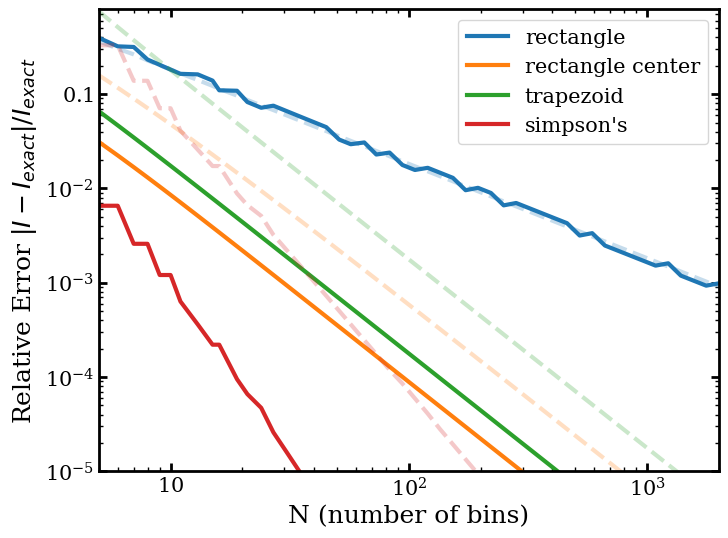

In [ ]:
'''
This cell is just for plotting the results of the convergence
test for the various integral types.
'''

pl.figure(figsize=(8,6))
labs = ['rectangle', 'rectangle center', 'trapezoid', "simpson's"]
for i in range(len(labs)):
    pl.plot(Ns, res[:,i,2], label=labs[i])
    pl.plot(Ns, res[:,i,1], ls='--', alpha=0.25, c="C"+str(i))
pl.ylim(bottom=1e-5)
pl.yscale("log")
pl.xscale("log")
pl.legend()
pl.xlabel("N (number of bins)")
pl.ylabel(r"Relative Error $|I-I_{exact}|/I_{exact}$")
pl.show()

The above plot shows the relative error of the methods as a function of the number of sub-intervals the integral is broken into. The solid lines are the errors relative to the analytical result, and the light, dashed lines are the error estimates I built into the methods. The methods converge in the order we expected, with the rectangle having the slowest convergence, followed by trapezoids, and then Simpson's method with the fastest convergence. I found it interesting that using rectangles, but evaulating the height at the midpoint, referred to as "rectangle center" above, coverges exactly as fast as the trapezoid rule. Interestingly, it is actually always more accurate than the trapezoid rule.

To get relative errors of $10^{-3}$ and $10^{-5}$, respectively took approximately the following number of sub-intervals for each of the methods:

Method / ~N for $10^{-3}$ error / ~N for $10^{-5}$ error
- Rectange / 1000 / $10^5$
- Trapezoid / 50 / 400
- Simpson's / 10 / 35


Interestingly, the quad function in Scipy achieves an accuracy far superior to any of my methods at these N. Although I could probably achieve $10^{-13}$ relative error with Simpson's at N~300. 

In [ ]:
'''
In this cell, I test the run time for the various integration
algorithms. Using timeit.repeat, I need the function calls as 
strings, so I store those in "calls". I can then loop over the
varying number of bins and methods to get the results.
Those are stored in the M x C x 2 array "times" where M is the
number of bin counts, C is the number of methods, and the last
axis holds the mean and standard deviation of the repeated run
times.
'''


calls = ['rect(f,a,b,N)',
         'rect_vec(f,a,b,N)',
         'rect_cen(f,a,b,N)',
         'trap(f,a,b,N)',
         'trap_vec(f,a,b,N)',
         'simpson(f,a,b,N)']

times = np.zeros((len(Ns), len(calls), 2))
for j in range(len(Ns)):
    for i in range(len(calls)):
        temp = timeit.repeat(calls[i].replace("N", str(Ns[j])), number=1000, repeat=5, globals=globals())
        times[j,i,0], times[j, i,1] = np.mean(temp)/1000, np.std(temp)/1000
        #note that I divide the mean and std by 1000 because the times are 
        # for the execution of the commands 1000 times

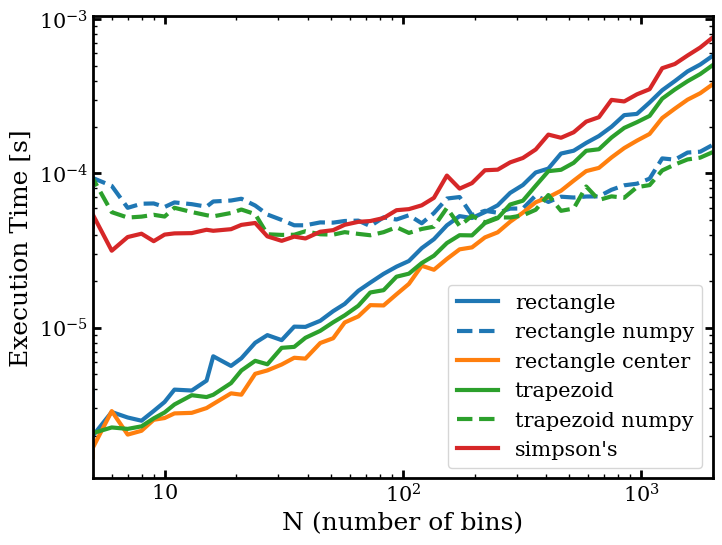

In [ ]:
'''
This cell simply creates the plot for run time versus number of bins
for the various methods.
'''

pl.figure(figsize=(8,6))
cols = ["C0", "C0", "C1", "C2", "C2", "C3"]
lss = [None, '--', None, None, '--', None]
labs = ["rectangle", "rectangle numpy", "rectangle center", "trapezoid",
        "trapezoid numpy", "simpson's"]
for i in range(len(calls)):
    pl.plot(Ns,times[:,i,0], c=cols[i], ls=lss[i], label=labs[i])

pl.xscale('log')
pl.yscale('log')
pl.legend()
pl.xlabel("N (number of bins)")
pl.ylabel("Execution Time [s]")
pl.show()

The above plot shows the time for execution of the various methods as a function of the number of sub-intervals used. The solid lines represent my Python loop implementations of the methods, while the dashed lines are for the methods I also vectorized using Numpy. The main take away I got from this plot is that for sufficiently large N, all the methods have the same time complexity, seeming to scale ~O(N). In fact, all the methods scale nearly identically execpt Simpson's rule, which suffers for small N. This is not such a weakness, though, as at small N the total execution time is so small that differences hardly matter. Another major takeaway is in the benefits of vectorization. Notice how the vectorization overhead slows the execution down by almost 2 orders of magnitude at low N, but then the time complexity appears to be ~O(1) all the way out to $10^3$ sub-intervals! I find this result facinating because it shows how the benefits of vectorization are not really felt until computations are done a substantial amount of time. Otherwise, the overhead is more costly than simply doing the loop in the Python.

Combining the timing results with the convergence results indicates that while there is some tradeoff between calculation speed and accuracy, it becomes less meaningful at large N. Simpson's rule is the clear winner here since it converges so incredibly fast and the regime where it is slowest is negligibly fast for all the methods. 

# Problem 2

In [ ]:
#initializing my random number generator
rng = np.random.default_rng(31415)

#defining all the relevant constants of the problem
m_total = 1e12 # solar masses
a = 35. # kpc
N = 1e7 # number of particles
G = 4.30092e-6 # kpc km2 / M_sol / s2

The goal of this problem is to sample velocities isotropically from a Hernquist profile. Many of the equations implemented here are taken directly from Hernquist (1990). 

My approach is the following:
- To sample from $p(E|r_i) = f(E) \sqrt{E - \phi_i}$ (where E is the total energy of the particle), I will use the acceptance-rejection technique since the function is not integrable analytically. 
- However, rejection sampling is very inefficient since $f(E)$ is, for the most part, a powerlaw. Therefore, I will create a sample which is similar to the target distribution using a bounding function and the inverse CDF method, followed by rejection sampling.
- For my bounding function, I chose $f(E) \sqrt{\phi_i}$ since this is always greater than the target. 

The following code executes this sampling technique and converts the resulting velocities into radial velocities to compare with the theoretical distribution.

In [ ]:
'''
In this cell, I define all the functions necessary for the velocity
sampling procedure. At the end, I also tabulate the CDF values for
my bounding function. 
'''

# Function for the Herquist radial profile
# Inputs: - r: radius (number or array)
#         - a (opt): characteristic radius of the halo
#         - M (opt): the total mass of the halo
# Returns: - Mass density at input r
def hernquist(r, a=a, M=m_total):
    return M*a/(2*np.pi * r * (r+a)**3)


# Cumulative mass, M(r), for the Herquist profile
# Inputs: - r: radius (number or array)
#         - a (opt): characteristic radius of the halo
#         - M (opt): the total mass of the halo
# Returns: - Integrated mass from 0 -> r
def m_r(r, a=a, M=m_total):
    return M * r**2 / (r+a)**2

# Inverse cumulative mass, r(M), for the Herquist profile
# Inputs: - m: integrated mass (number or array)
#         - a (opt): characteristic radius of the halo
#         - M (opt): the total mass of the halo
# Returns: - Radius at which M(r) = m
def r_m(m, a=a, M=m_total):
    return a/((M/m)**0.5 - 1)


# Gravitational Potential for Herquist profile
# Inputs: - r: radius (number or array)
#         - a (opt): characteristic radius of the halo
#         - M (opt): the total mass of the halo
# Returns: - Gravitational potential at r
def phi(r, a=a, M=m_total):
    return -G*M/(r+a)

# Energy distribution function for Herquist profile
#  Eq. 17 in Herquist (1990)
# Inputs: - E: energy (number or array)
#         - a (opt): characteristic radius of the halo
#         - M (opt): the total mass of the halo
# Returns: - Phase space density for E
def f_E(E, a=a, M=m_total):
    #save the repeated factors
    q = np.sqrt(-a*E/G/M)
    vg = np.sqrt(G*M/a)

    #initialize array for output
    out = np.zeros(len(E))

    #note that f(E) diverges as q -> 1, so to avoid numerical errors,
    # let everywhere q >= 1 return 0
    mask = q < 1
    qm = q[mask]
    out[mask] = M / (8 * 2**0.5 * np.pi**3 * vg**3 * (1-qm**2)**(5/2)) * \
        (3*np.arcsin(qm) + qm*(1-qm**2)**0.5 * (1-2*qm**2) * (8*qm**4-8*qm**2-3))
    return out

# Marginal PDF of energy given r [f(E)*sqrt(E-phi)]
# Inputs: - E: energy (number or array)
#         - r: radius (number or array)
# Returns: - probability density of E given r
def p_er(e,r):
    # Initialize 0s and use a mask to avoid singular regions
    #  where E < phi(r) or E > 0
    ps = np.zeros(len(e))
    cond = (e >= phi(r)) & (e <= 0)
    ps[cond] = f_E(e[cond]) * np.sqrt(e[cond] - phi(r[cond]))
    return ps


# Bounding function used for sampling [f(E)*sqrt(-phi(r))]
# Inputs: - E: energy (number or array)
#         - r: radius (number or array)
# Returns: - value(s) always greater than p_er
def bound(e, r):
    #notice that this works as a bounding function because 
    # E is strictly > phi(R) since E = phi(R) would refer to a 
    # stationary particle.
    return f_E(e) * np.sqrt(-phi(r))

# Inverse of bounding function CDF
# Inputs: - x: Value of \int_0^{E} bound dE
# Returns: - E cooresponding to x = \int_0^E bound dE
#
# Notice that I've ignored the sqrt(-phi(r)) factor because
# it is a simple scaling that doesn't affect the shape
#
# fE_int_tab is an array holding the tabulated numerical integral
# for f(E). It is generated later in this cell. This function 
# simply interpolates the tabulated values.
def inv_bound_cdf(x):
    return np.interp(x, fE_int_tab[1,:], fE_int_tab[0,:])


# Workhorse function to generate a sample of energies following
# a Herquist distribution given a list of radii
# Inputs: - rs: radii (number or array)
#         - phis: gravitational potential, phi(rs) (number or array)
# Returns: - Array of energies following Herquist distribution, with
#             0s for any rejected points
def sample_Es(rs, phis):

    # Sample the bounding CDF
    #   Interpolate the max CDF value based on phi(r)
    #   It is -fE_int_tab[0,:] because those decreasing negative 
    #    energies and interp assumes monotonically increasing grid points.
    cdf_norm = np.interp(-phis, -fE_int_tab[0,:], fE_int_tab[1,:])
    # generate random CDF values (note not 0-1 but 0-max)
    rands = rng.random(len(rs)) * cdf_norm
    # invert CDF values to get energies following bounding function distribution
    Es = inv_bound_cdf(rands, rs)

    # Rejection sample the bounding distribution sample to arrive at
    #  the target distribution
    # We want to draw samples from 0-bound and reject if they are greater 
    #  than the target
    mult_factor = bound(Es, rs)
    reject_rands = rng.random(len(rs)) * mult_factor
    # set rejected points to 0
    Es[reject_rands > p_er(Es,rs)] = 0
    return Es

# Mean squared velocity for Herquist profile
#  Eq. 10 of Hernquist (1990)
# Inputs: - r: radius (number or array)
#         - a (opt): characteristic radius of the halo
#         - M (opt): the total mass of the halo
# Returns: - Mean v^2 at r
def v2_mean(r, a=a, M=m_total):
    return G*M / 12 / a * (12*r * (r+a)**3 / a**4 * np.log((r+a)/r) \
             - r / (r+a) * (25 + 52* r/a + 42* (r/a)**2 + 12* (r/a)**3))


# This code tabulates the f(E) integral
#  Initialize array to hold E and \int_0^E f(E) dE
fE_int_tab = np.zeros((2,int(1e5)))
#  Fill in E values in log space
fE_int_tab[0,:] = -np.logspace(-3,np.log10(G*m_total/a-1), int(1e5))
#  Precompute the f(E) values
fEs = f_E(fE_int_tab[0,:])
#  Loop over all the E points
for i in range(1,len(fE_int_tab[0])):
    # Rather than recompute the full integral each time, simply add the integration of the
    #  current point to the running integral stored in the previous position
    # Note that sci_simp refers to scipy.simpson, but is named differently to 
    #  differentiate from my implementation of simpson's rule for Problem 1
    fE_int_tab[1,i] = fE_int_tab[1,i-1] + sci_simp(fEs[i-1:i+1], x=-fE_int_tab[0,i-1:i+1])

In [ ]:
'''
This cell executes the procedure of generating the velocity distribution
using the functions implemented in the previous cell
'''

# Sample Herquist distributed radii
#   Start by generating uniformly in enclosed mass
radii = rng.random(int(N)) * m_total
#   Invert enclosed mass to get radii
radii = r_m(radii)
# Compute phi for each r
phis = phi(radii)
# Initialize array for energies
Es = np.zeros(len(radii))
# Initialize mask which holds boolean value for each element of Es
#  checking whether it is 0 or not
is_zero = (Es == 0)
# Since True evaulates as 1 in a sum, we can check if there are 0s
#  in the energy distribution by summing the mask.
# We'll keep sampling until there are no longer 0s. Recall that 0s
#  represent rejected points
while sum(is_zero) > 0:
    # Call our function to generate the E distribution
    #  Notice I only generate new Es for those which are currently 0.
    #  That way I only try again for failed points.
    Es[is_zero] = sample_Es(radii[is_zero], phis[is_zero])
    # Re-evaluate the mask
    is_zero = (Es == 0)
    

# With E values, we simply use E = v^2 / 2 + phi(r) to generate v
vs = np.sqrt(2 * (Es - phis))

# We need to get radial components of v.
# To do so, imagine all our points along z axis. This does not
#  lost generality because the important thing is that the 
#  velocity vector be random *relative to the radius vector*. 
#  Therefore, since we generate a velocity vector at random, 
#  We are free to choose any radius vector we want. The easiest
#  choice is the z-axis since we need only generate the polar
#  angle, theta, to compute v_r = v_z = v /dot z_hat = v * cos(theta)
v_pol_ang = np.arccos(2 * rng.random(len(vs)) - 1)
vr = vs * np.cos(v_pol_ang)

# I then sort the radii and velocity pairs to make binning easier
sort_r = np.argsort(radii)
radii = radii[sort_r]
vr = vr[sort_r]

# Initialize the bin edges
bin_edges = np.logspace(np.log10(min(radii)), np.log10(max(radii)), 100)
# Compute the bin centers
bin_mid = bin_edges[:-1] * np.sqrt(bin_edges[1]/bin_edges[0])

vr_binned = np.zeros(len(bin_mid))
count_binned = np.zeros(len(bin_mid))

# Loop over the bins and compute the relevant values.
# To get the density distribution, we simply count the number
#  of points in each radius bin. To get the mean v_r^2 distribution
#  we bin those values.
for i in range(len(bin_mid)):
    mask = (radii >= bin_edges[i]) & (radii < bin_edges[i+1])
    vr_binned[i] = np.mean(vr[mask]**2)
    count_binned[i] = sum(mask)

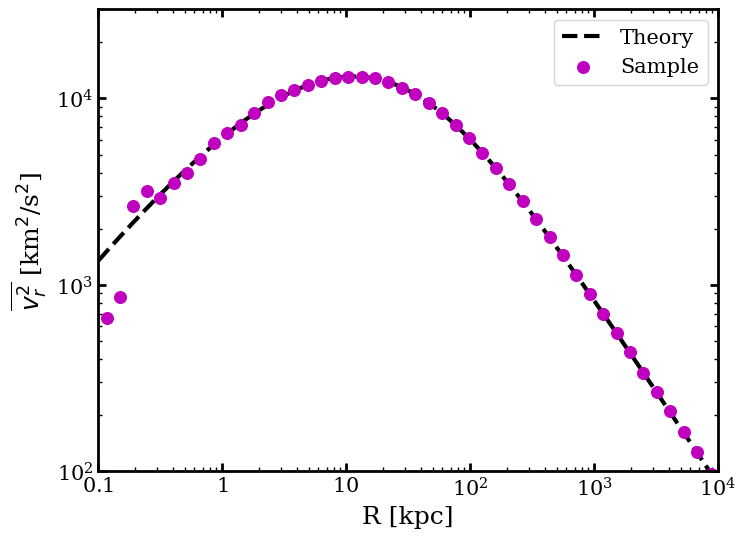

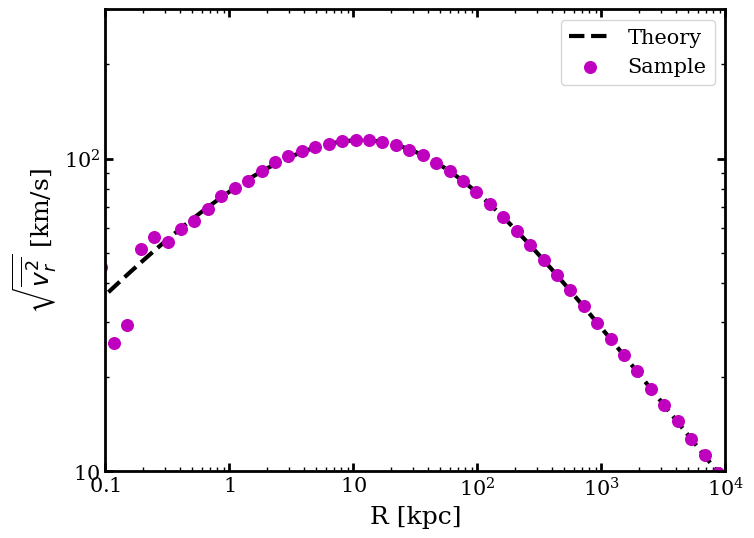

In [47]:
'''
In this cell, I plot the radial velocity distribution to compare
with the theoretical result.
'''

pl.figure(figsize=(8,6))
vs = v2_mean(bin_mid)

pl.plot(bin_mid, np.abs(vs), ls="--",c='k', label="Theory", zorder=1)
pl.scatter(bin_mid, vr_binned, c='m', s=70, zorder=2, label="Sample")
pl.xlim(0.1,1e4)
pl.ylim(1e2, 3e4)
pl.xscale('log')
pl.yscale('log')
pl.ylabel(r"$\overline{v^2_r}$ [km$^2$/s$^2$]")
pl.xlabel("R [kpc]")
pl.legend()
pl.show()

pl.figure(figsize=(8,6))
pl.plot(bin_mid, np.sqrt(np.abs(vs)), ls="--",c='k', label="Theory", zorder=1)
pl.scatter(bin_mid, np.sqrt(vr_binned), c='m', s=70, zorder=2, label="Sample")
pl.xlim(0.1,1e4)
pl.ylim(1e1, 3e2)
pl.xscale('log')
pl.yscale('log')
pl.ylabel(r"$\sqrt{\overline{v^2_r}}$ [km/s]")
pl.xlabel("R [kpc]")
pl.legend()
pl.show()

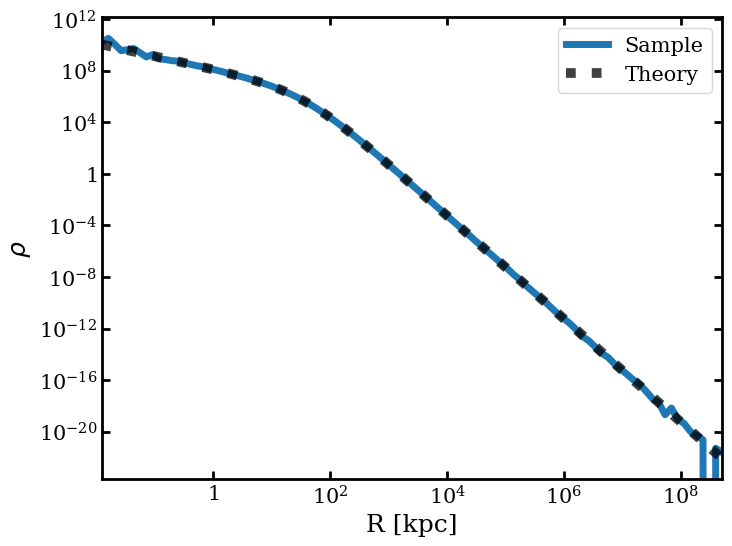

In [ ]:
'''
This cell plots the radial distribution of my sample as a 
test against the analytical Hernquist distribution.
'''

rho_bin = count_binned * (m_total / N) / (4 * np.pi * bin_mid**3 * np.log10(bin_mid[1]/bin_mid[0]) * np.log(10))
hern_bin = hernquist(bin_mid) * 4 * np.pi * bin_mid**3

pl.figure(figsize=(8,6))
pl.loglog(bin_mid, rho_bin, label="Sample", lw=5)
pl.plot(bin_mid, hernquist(bin_mid), c='k', alpha=0.75, ls='dotted', lw=7, label="Theory")
pl.ylabel(r"$\rho$")
pl.xlabel("R [kpc]")
pl.legend()
pl.show()

In [57]:
'''
This cell copies the code from above to execute the sampling, but
I've removed the repeated comments and modified it to investigate
the efficiency.
'''

N = 1e6

#initialize a timer
t0 = time.time()

radii1 = rng.random(int(N)) * m_total
radii1 = r_m(radii1)
phis1 = phi(radii1)

t1 = time.time()

Es1 = np.zeros(len(radii1))
is_zero1 = (Es1 == 0)

count = 0
redone = np.zeros(len(radii1))

looptimes = [time.time()]

while sum(is_zero1) > 0:
    redone[is_zero1] += 1
    Es1[is_zero1] = sample_Es(radii1[is_zero1], phis1[is_zero1])
    is_zero1 = (Es1 == 0)
    count += 1
    looptimes.append(time.time()-looptimes[-1])
    

t2 = time.time()

vs1 = np.sqrt(2 * (Es1 - phis1))
v_pol_ang1 = np.arccos(2 * rng.random(len(vs1)) - 1)
vr1 = vs1 * np.cos(v_pol_ang1)

t3 = time.time()

sort_r1 = np.argsort(radii1)
radii1 = radii1[sort_r1]
vr1 = vr1[sort_r1]
redone = redone[sort_r1]

t4 = time.time()

# Initialize the bin edges
bin_edges1 = np.logspace(np.log10(min(radii1)), np.log10(max(radii1)), 100)
# Compute the bin centers
bin_mid1 = bin_edges1[:-1] * np.sqrt(bin_edges1[1]/bin_edges1[0])

vr_binned1 = np.zeros(len(bin_mid1))
count_binned1 = np.zeros(len(bin_mid1))
redone_count1 = np.zeros(len(bin_mid1))


for i in range(len(bin_mid1)):
    mask = (radii1 >= bin_edges1[i]) & (radii1 < bin_edges1[i+1])
    vr_binned1[i] = np.mean(vr1[mask]**2)
    count_binned[i] = sum(mask)
    redone_count1[i] = sum(redone[mask])

t5 = time.time()


/home/owen/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/owen/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [58]:
print(f"""
      Times:

      Radii sampling: {t1 - t0:.5f} s\n
      Energy sampling: {t2 - t1:.5f} s\n
      v -> v_r: {t3 - t2:.5f} s\n
      Sorting: {t4 - t3:.5f} s\n
      Binning: {t5 - t4:.5f} s\n


      For {N:.0e} particles, the code looped over the energy
      distribution step {count} times and rejected a total of 
      {np.sum(redone) - N:0.2e} samples.
      """)


      Times:

      Radii sampling: 0.01948 s

      Energy sampling: 15.90805 s

      v -> v_r: 0.11273 s

      Sorting: 0.61085 s

      Binning: 12.58018 s



      For 1e+06 particles, the code looped over the energy
      distribution step 79 times and rejected a total of 
      1.53e+06 samples.
      


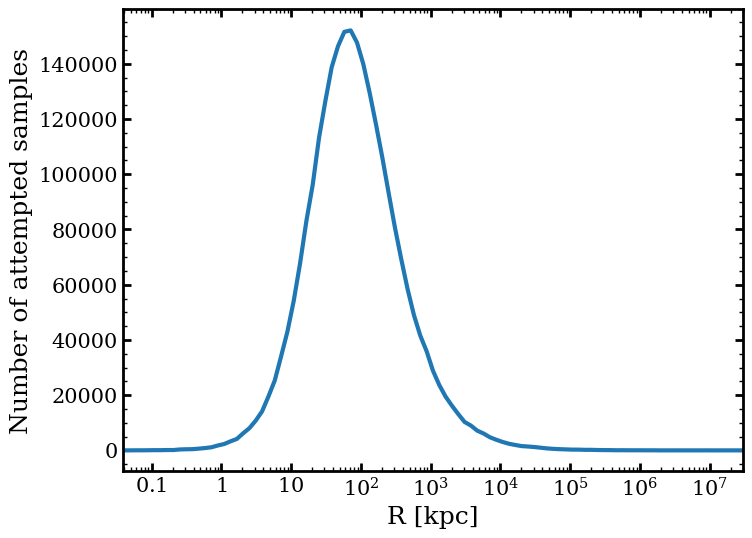

In [60]:
pl.figure(figsize=(8,6))
pl.plot(bin_mid1, redone_count1)
pl.xscale("log")
pl.xlabel("R [kpc]")
pl.ylabel("Number of attempted samples")
pl.show()

The first thing to point out is that the code works tremendously well. In the first run, which sampled $10^7$ particles, the resulting distribution follows the theory curve remarkably. There is more scatter at small R, but this is due to the small numbers of points there. That run took ~7 minutes to run on my (relatively old) laptop. With $10^6$ particles, it easily runs in under a minute. 

To further investigate the performance, I ran the code again, but this time benchmarked the time taken for each step. The slowest steps, which each took about half the time were the sampling of th energies and the binning. I suspect that the binning scales much better with N than the energy sampling, though. I also recorded the number of rejected samples, which turned out to be on the same order as N, ~$10^6$. In other words, to get $10^6$ energies, I have to sample about twice as many as that from the bounding function. An average of a 50% rejection I consider quite efficient given the nature of the target function.

I also recorded which radii needed energies resampled the most time. The binned results are above. The distribution is very Gaussian (with a bit of skew to the right) overall. It seems that my code is least efficient at sampling energies for radii in the intermediate regime at about the characteristic scale of the halo, $a$. I suspect this is because larger radii have very little available E space since the potential is shallower and at smaller radii the bounding function very closely matches the target because they both diverge, so the multiplicative constant separating them diminishes in importance.